## 人像抠图

In [1]:
import requests
import base64
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [2]:
def get_access_token(client_id, client_secret):
    '''
    function: 调用鉴权接口获取access_token
    parameter: client_id：API Key
                client_secret：Secret Key
    return: 获取的access_token
    '''
    host = 'https://aip.baidubce.com/oauth/2.0/token?grant_type=client_credentials&client_id={}&client_secret={}'
    response = requests.get(host.format(client_id, client_secret))
    responseText = json.loads(response.text)
    # print(responseText)
    access_token = responseText['access_token']
    
    return access_token

In [3]:
def get_responsetext(original_image, access_token):
    '''
    function: 调用API进行人像分割
    parameter: original_image待抠图的原始图像
                access_token获取的access_token
    return: API处理过的分割图像response
    '''
    request_url = "https://aip.baidubce.com/rest/2.0/image-classify/v1/body_seg"
    # 二进制方式打开图片文件,用以网络传输
    f = open(original_image, 'rb')
    img = base64.b64encode(f.read())
    params = {"image":img}
    request_url = request_url + "?access_token=" + access_token
    headers = {'content-type': 'application/x-www-form-urlencoded'}
    response = requests.post(request_url, data=params, headers=headers)
    responseText = json.loads(response.text)
    return responseText

In [4]:
def bufferedImage_to_png(original_image, output_image, responsetext, types):
    '''
    function: 返回值解码保存图片
    parameter: original_image待抠图的原始图像
                output_image处理后的图像存储路径
                responsetext百度API处理后返回的response
                types要获取分割后的图像类型（二值结果图、灰度图、透明背景的人像图）可选:（labelmap,scoremap,foreground）
    return None
    '''
    b64_ecode_img = base64.b64decode(responsetext[types])
    nparr = np.frombuffer(b64_ecode_img, np.uint8)
    cv2_decode_img = cv2.imdecode(nparr, 1)
    height, width, depth = cv2.imread(original_image).shape
    # width, height为图片原始宽、高
    result_img = cv2.resize(cv2_decode_img, (width, height), interpolation=cv2.INTER_NEAREST)
    im_new = np.where(result_img==1, 255, result_img)
    cv2.imwrite(output_image, im_new)

In [5]:
def original_without_background(original_image, labelmap_image, output_image):
    '''
    function: 在原图上抠掉二值图的背景区域，达到人像抠图效果
    parameter: original_image待抠图的原始图像
                labelmap_image百度API处理过的二值图像
                output_image抠掉背景图后的图像存储路径
    return: none
    '''
    baseimg = cv2.imread(original_image)
    labelmap = cv2.imread(labelmap_image)
    im_new = np.where(labelmap==0,255,baseimg)
    cv2.imwrite(output_image, im_new)
    

In [6]:
def rgb_add_alpha(image, output_image):
    '''
    function: 给RGB图像添加alpha通道
    parameter: image需要添加alpha通道的图像
                output_image添加完alpha通道的图像存储路径
    return: none
    '''
    #将生成的新图像添加alpha通道
    img = cv2.imread(image)
    if img.shape[2] == 4:
        print('图像已包含alpha通道')
        return
    b_channel, g_channel, r_channel = cv2.split(img)
    # 设置背景图RGB通道都对应为255的像素点，透明度为0(完全透明)，其他的像素点透明度为255(完全不透明)
    alpha_channel = np.ones(b_channel.shape, dtype=b_channel.dtype) * 255
    # 将背景区域(RGB三通道都为255的像素点)alpha设为0
    alpha_channel = np.where(b_channel*g_channel*r_channel==255**3, 0, alpha_channel)
    img_BGRA = cv2.merge((b_channel, g_channel, r_channel, alpha_channel))
    cv2.imwrite(output_image, img_BGRA)
#     lena = cv2.imread(output_image,cv2.IMREAD_UNCHANGED)
#     print(lena.shape)

In [7]:
def display_images(original_image, labelmap_image, scoremap_image, foreground_image, merge_labelmap_original_image, lena, save_fig):
    '''
    function: 展示图像
    parameter: original_image原始图像 
                labelmap_image二值图像 
                scoremap_image人像前景灰度图 
                foreground_image人像前景抠图，透明背景
                lena通过原始图像，二值图像合成的人像前景抠图，透明背景
    return none
    '''
    images = [('original',original_image), 
              ('labelmap',labelmap_image), 
              ('scoremap',scoremap_image), 
              ('foreground',foreground_image), 
              ('merge_labelmap_original',merge_labelmap_original_image),
              ('lena',lena)]
    fig = plt.figure(figsize=(20,10))

    for index,item in enumerate(images):

        plt.subplot(2,len(images)/2,index+1)
        img = Image.open(item[1])
        plt.title('{}-channels:{}'.format(item[0],len(img.split())))

        plt.imshow(img)

    #使得子图横纵坐标更加紧凑，主要用于自动调整图区的大小以及间距，使所有的绘图及其标题、坐标轴标签等都可以不重叠的完整显示在画布上。
    fig.tight_layout()
    plt.savefig(save_fig)
    plt.show()

In [8]:
def image_processing(access_token, original_image, labelmap_image, scoremap_image, foreground_image, merge_labelmap_original_image, lena, save_fig):

    # 获取图像经AIP处理后的responsetext
    responsetext = get_responsetext(original_image, access_token)
    # 将返回的二值图像解码保存
    bufferedImage_to_png(original_image, labelmap_image, responsetext, 'labelmap')
    # 将返回的人像前景灰度图解码保存
    bufferedImage_to_png(original_image, scoremap_image, responsetext, 'scoremap')
    # 将返回的人像前景抠图解码保存
    bufferedImage_to_png(original_image, foreground_image, responsetext, 'foreground')
    # #在原图上抠掉二值图的背景区域
    original_without_background(original_image, labelmap_image, merge_labelmap_original_image)
    # 给RGB图像添加alpha通道
    rgb_add_alpha(merge_labelmap_original_image, lena)
    #显示图像
    display_images(original_image, labelmap_image, scoremap_image, foreground_image, merge_labelmap_original_image, lena, save_fig)

In [9]:
# API Key  &&  Secret Key
client_id = 'M1hAGDsgNLXvVNlQXONHGvwI'
client_secret = 'eICwvgUcyKdUNGQNAXfCCOGDsHv2Urmq'
# 获取access_token
access_token = get_access_token(client_id, client_secret)

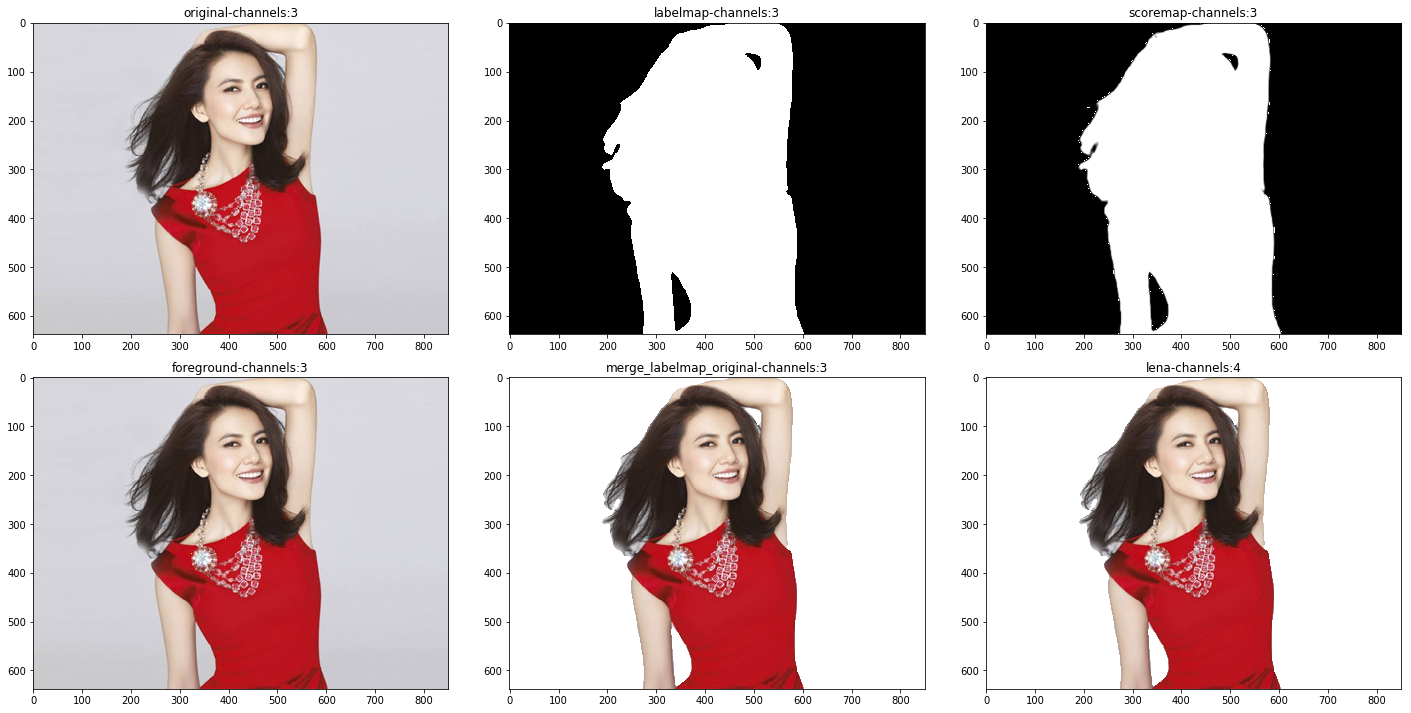

In [10]:
# 待测试图像
original_image_gaoyuanyuan = 'images/gaoyuanyuan.jpg'
labelmap_image_gaoyuanyuan = 'images/gaoyuanyuan_labelmap.png'
scoremap_image_gaoyuanyuan = 'images/gaoyuanyuan_scoremap.png'
foreground_image_gaoyuanyuan = 'images/gaoyuanyuan_foreground.png'
merge_labelmap_original_image_gaoyuanyuan = 'images/gaoyuanyuan_without_bg.png'
lena_gaoyuanyuan = 'images/gaoyuanyuan_lena.png'
save_fig_gaoyuanyuan = 'images/gaoyuanyuan_save_fig.png'

image_processing(access_token, 
                 original_image_gaoyuanyuan, 
                 labelmap_image_gaoyuanyuan, 
                 scoremap_image_gaoyuanyuan, 
                 foreground_image_gaoyuanyuan, 
                 merge_labelmap_original_image_gaoyuanyuan, 
                 lena_gaoyuanyuan, 
                 save_fig_gaoyuanyuan)

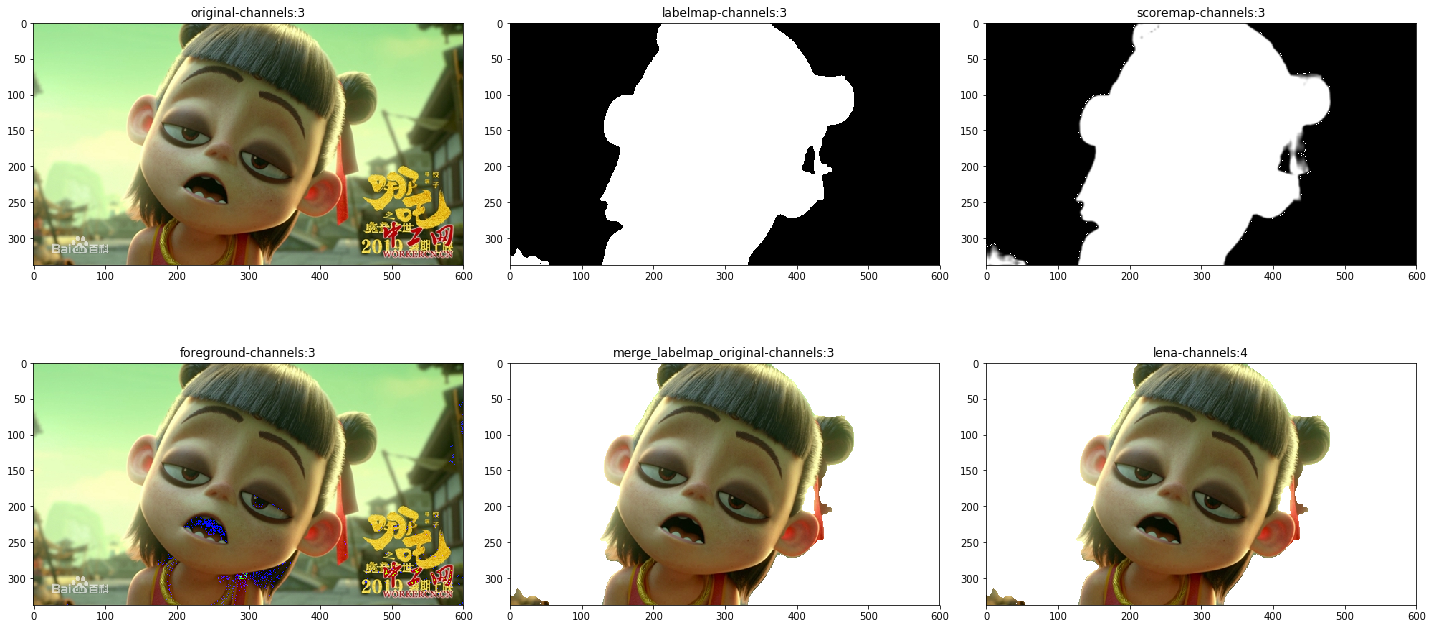

In [11]:
# 待测试图像
original_image_nezha = 'images/nezha.jpg'
labelmap_image_nezha = 'images/nezha_labelmap.png'
scoremap_image_nezha = 'images/nezha_scoremap.png'
foreground_image_nezha = 'images/nezha_foreground.png'
merge_labelmap_original_image_nezha = 'images/nezha_without_bg.png'
lena_nezha = 'images/nezha_lena.png'
save_fig_nezha = 'images/nezha_save_fig.png'

image_processing(access_token, 
                 original_image_nezha, 
                 labelmap_image_nezha, 
                 scoremap_image_nezha, 
                 foreground_image_nezha, 
                 merge_labelmap_original_image_nezha, 
                 lena_nezha, 
                 save_fig_nezha)

##  图像合成（背景替换）

(338, 600, 3)
(575, 1024, 3)


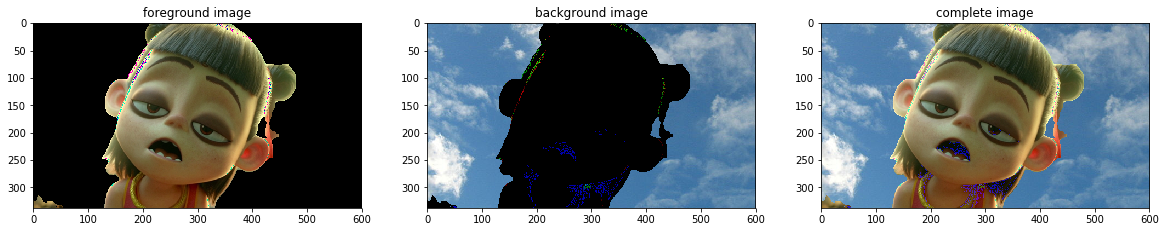

In [74]:
foreground_img = cv2.imread(merge_labelmap_original_image_nezha)
background_img = cv2.imread('images/sky.jpg')
# 一定要确保背景图片size大于前景图片
print(foreground_img.shape)
print(background_img.shape)
fg_height,fg_width,fg_depth = foreground_img.shape
bg_height,bg_width,bg_depth = background_img.shape
# 在背景图中间取出跟前景图同样大小的图像
background_img_crop = np.copy(background_img)[(bg_height - fg_height)//2:((bg_height - fg_height)//2 + fg_height),
                                (bg_width - fg_width)//2:((bg_width - fg_width)//2 + fg_width)]
# 前景图抠掉背景
foreground_img = np.where(foreground_img==255,0,foreground_img)
# 背景图抠掉同等位置的人像占位
background_img_crop = np.where(foreground_img!=0,0,background_img_crop)
# 前景图与背景图合成
complete_image = background_img_crop + foreground_img

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(20,5))
ax0.set_title('foreground image')
# 将cv2读取的BGR图像转化为RGB图像
ax0.imshow(foreground_img[:,:,::-1])
ax1.set_title('background image')
ax1.imshow(background_img_crop[:,:,::-1])
ax2.set_title('complete image')
ax2.imshow(complete_image[:,:,::-1])

plt.savefig('images/background_replace_save_fig.png')